In [1]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.4 MB 1.2 MB/s eta 0:00:02
   --------- ------------------------------ 0.3/1.4 MB 3.0 MB/s eta 0:00:01
   ------------------- -------------------- 0.7/1.4 MB 4.0 MB/s eta 0:00:01
   ---------------------------------- ----- 1.2/1.4 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 6.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from scipy.stats import spearmanr

In [3]:
train_data = pd.read_csv("train.csv")  
val_data = pd.read_csv("val.csv")     
test_data = pd.read_csv("test.csv")    

In [4]:
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

In [6]:
def extract_features(data):
    data["sentence_length"] = data["text"].apply(len)
    data["word_count"] = data["text"].apply(lambda x: len(x.split()))
    data["avg_word_length"] = data["text"].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
    )
    data["punctuation_count"] = data["text"].str.count(r"[^\w\s]")
    return data[["sentence_length", "word_count", "avg_word_length", "punctuation_count"]]

In [12]:
x_train = extract_features(train_data)
y_train = train_data["score"]

x_val = extract_features(val_data)
y_val = val_data["score"]

X_test = extract_features(test_data)

In [16]:
from lightgbm import early_stopping

# Callback for early stopping
callbacks = [early_stopping(stopping_rounds=50, verbose=True)]

# Train the model with callbacks
lgb_model = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
lgb_model.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric="rmse", callbacks=callbacks)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4
[LightGBM] [Info] Start training from score 0.520791
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's rmse: 0.812291	valid_0's l2: 0.659817


LGBMRegressor(learning_rate=0.05, n_estimators=500, random_state=42)

In [17]:
y_val_pred = lgb_model.predict(x_val)
spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation:", spearman_corr)

Validation Spearman Correlation: 0.06544091085924854


In [19]:
!pip install textstat

   ---------------------------------------- 0.0/105.1 kB ? eta -:--:--
   ----------- --------------------------- 30.7/105.1 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 105.1/105.1 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB 6.5 MB/s eta 0:00:01
   ------------ --------------------------- 0.6/2.1 MB 6.6 MB/s eta 0:00:01
   ---------------------- ----------------- 1.2/2.1 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 12.1 MB/s eta 0:00:00


In [22]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 656.4 kB/s eta 0:03:11
   ---------------------------------------- 0.2/124.9 MB 1.3 MB/s eta 0:01:36
   ---------------------------------------- 0.4/124.9 MB 2.3 MB/s eta 0:00:56
   ---------------------------------------- 0.7/124.9 MB 3.0 MB/s eta 0:00:42
   ---------------------------------------- 0.9/124.9 MB 3.4 MB/s eta 0:00:37
    --------------------------------------- 1.6/124.9 MB 5.2 MB/s eta 0:00:24
    --------------------------------------- 2.1/124.9 MB 5.9 MB/s eta 0:00:21
    --------------------------------------- 3.1/124.9 MB 7.5 MB/s eta 0:00:17
   - -------------------------------------- 3.9/124.9 MB 9.0 MB/s eta 0:00:14
   - -------------------------------------- 5.0/124.9 MB 10.2 MB/s eta 0:00:12
   - -------------------------------------- 6.0/124.9 MB 11.3 MB/s eta 0:00

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from scipy.stats import spearmanr
from textstat import flesch_reading_ease, gunning_fog
import spacy
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import VotingRegressor

# Load spaCy model for POS tagging
nlp = spacy.load("en_core_web_sm")

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- Feature Engineering ---
def extract_features(df):
    # Basic Features
    df["sentence_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    df["avg_word_length"] = df["text"].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df["punctuation_count"] = df["text"].str.count(r"[^\w\s]")
    df["question_count"] = df["text"].str.count(r"\?")
    df["exclamation_count"] = df["text"].str.count(r"!")
    
    # Lexical Features
    df["type_token_ratio"] = df["text"].apply(lambda x: len(set(x.split())) / (len(x.split()) + 1e-5))
    df["stopword_count"] = df["text"].apply(lambda x: sum(1 for word in x.split() if word.lower() in spacy.lang.en.stop_words.STOP_WORDS))
    
    # Readability Metrics
    df["flesch_reading_ease"] = df["text"].apply(lambda x: flesch_reading_ease(x))
    df["gunning_fog"] = df["text"].apply(lambda x: gunning_fog(x))
    
    # Syntactic Features (POS Tag Distribution)
    def pos_counts(text):
        doc = nlp(text)
        pos_tags = [token.pos_ for token in doc]
        return {tag: pos_tags.count(tag) for tag in set(pos_tags)}
    
    pos_features = df["text"].apply(pos_counts)
    pos_df = pd.DataFrame(pos_features.tolist()).fillna(0)
    df = pd.concat([df.reset_index(drop=True), pos_df.reset_index(drop=True)], axis=1)
    
    return df.drop(columns=["text"])

# Extract features for training, validation, and testing
X_train = extract_features(train_data)
y_train = train_data["score"]

X_val = extract_features(val_data)
y_val = val_data["score"]

X_test = extract_features(test_data)

# --- Align Feature Columns ---
def align_features(train_df, other_df):
    # Add missing columns to other_df
    for col in train_df.columns:
        if col not in other_df.columns:
            other_df[col] = 0
    # Drop extra columns in other_df
    for col in other_df.columns:
        if col not in train_df.columns:
            other_df.drop(columns=[col], inplace=True)
    # Reorder columns to match train_df
    return other_df[train_df.columns]

# Align validation and test datasets to match the training dataset
X_val = align_features(X_train, X_val)
X_test = align_features(X_train, X_test)


# --- Feature Selection ---
selector = SelectKBest(score_func=f_regression, k=20)
X_train = selector.fit_transform(X_train, y_train)
X_val = selector.transform(X_val)
X_test = selector.transform(X_test)

# --- Model Tuning ---
# Combine LightGBM and XGBoost in a voting regressor for an ensemble
from xgboost import XGBRegressor

lgb_model = LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=10, num_leaves=50, random_state=42)
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=10, random_state=42)

ensemble_model = VotingRegressor([("lgb", lgb_model), ("xgb", xgb_model)])
ensemble_model.fit(X_train, y_train)

# --- Evaluate on Validation Set ---
y_val_pred = ensemble_model.predict(X_val)
spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation:", spearman_corr)




[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 19
[LightGBM] [Info] Start training from score 0.520791
Validation Spearman Correlation: 0.9984565868418234


In [24]:
# --- Generate Predictions for Test Set ---
y_test_pred = ensemble_model.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("jovolukic24.csv", index=False)

print("Sample submission file 'jovolukic24.csv' generated successfully!")

Sample submission file 'jovolukic24.csv' generated successfully!


In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- Feature Engineering ---
def extract_features(df):
    # Basic Features
    df["sentence_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    df["avg_word_length"] = df["text"].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df["punctuation_count"] = df["text"].str.count(r"[^\w\s]")
    df["stopword_count"] = df["text"].apply(lambda x: sum(1 for word in x.split() if word.lower() in spacy.lang.en.stop_words.STOP_WORDS))
    return df[["sentence_length", "word_count", "avg_word_length", "punctuation_count", "stopword_count"]]

# Extract features
X_train = extract_features(train_data)
y_train = train_data["score"]

X_val = extract_features(val_data)
y_val = val_data["score"]

X_test = extract_features(test_data)

# --- Ridge Regression ---
# Initialize Ridge Regression with hyperparameter tuning
alphas = [0.1, 1.0, 10.0, 100.0]  # Regularization strengths to try
best_alpha = None
best_score = -np.inf

# Perform cross-validation to find the best alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring=spearman_scorer)
    mean_score = np.mean(scores)
    print(f"Alpha: {alpha}, Cross-Validation Spearman Correlation: {mean_score}")
    if mean_score > best_score:
        best_alpha = alpha
        best_score = mean_score

print(f"Best Alpha: {best_alpha}, Best Cross-Validation Score: {best_score}")

# Train final model with best alpha
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = ridge.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation:", val_spearman_corr)

Alpha: 0.1, Cross-Validation Spearman Correlation: 0.1047050169953134
Alpha: 1.0, Cross-Validation Spearman Correlation: 0.1047905505049009
Alpha: 10.0, Cross-Validation Spearman Correlation: 0.10483451657655958
Alpha: 100.0, Cross-Validation Spearman Correlation: 0.10255178453565819
Best Alpha: 10.0, Best Cross-Validation Score: 0.10483451657655958
Validation Spearman Correlation: 0.0764112318103484


In [ ]:
# --- Generate Predictions for Test Set ---
y_test_pred = ridge.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("sample_submission.csv", index=False)

print("Sample submission file 'sample_submission.csv' generated successfully!")

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
from lightgbm import LGBMRegressor

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- Feature Engineering ---
def extract_features(df):
    df["sentence_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    df["avg_word_length"] = df["text"].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df["punctuation_count"] = df["text"].str.count(r"[^\w\s]")
    df["type_token_ratio"] = df["text"].apply(lambda x: len(set(x.split())) / (len(x.split()) + 1e-5))
    return df[["sentence_length", "word_count", "avg_word_length", "punctuation_count", "type_token_ratio"]]

X_train = extract_features(train_data)
y_train = train_data["score"]

X_val = extract_features(val_data)
y_val = val_data["score"]

X_test = extract_features(test_data)

# --- Model Training: LightGBM ---
lgb_model = LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="rmse", callbacks=[early_stopping(stopping_rounds=50, verbose=True)])

# --- Evaluate on Validation Set ---
y_val_pred = lgb_model.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation:", val_spearman_corr)




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Info] Start training from score 0.520791
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
# --- Generate Predictions for Test Set ---
y_test_pred = lgb_model.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("sample_submission.csv", index=False)

print("Sample submission file 'sample_submission.csv' generated successfully!")

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- TF-IDF Vectorization ---
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    ngram_range=(1, 2),  # Unigrams and bigrams
    stop_words="english"  # Remove common stopwords
)

# Fit TF-IDF on the training data and transform the datasets
X_train = tfidf.fit_transform(train_data["text"])
y_train = train_data["score"]

X_val = tfidf.transform(val_data["text"])
y_val = val_data["score"]

X_test = tfidf.transform(test_data["text"])

# --- Linear Regression ---
# Initialize and train the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# --- Evaluate on Validation Set ---
y_val_pred = linear_model.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation:", val_spearman_corr)

# --- Cross-Validation ---
cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring=spearman_scorer)
print("Cross-Validation Spearman Correlation Scores:", cv_scores)
print("Mean Spearman Correlation (CV):", cv_scores.mean())




Validation Spearman Correlation: 0.4123602272416702
Cross-Validation Spearman Correlation Scores: [0.36257665 0.33906107 0.34410552 0.32748827 0.33575692]
Mean Spearman Correlation (CV): 0.3417976865078033


In [29]:
# --- Generate Predictions for Test Set ---
y_test_pred = linear_model.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("sample_submission.csv", index=False)

print("Sample submission file 'sample_submission.csv' generated successfully!")

Sample submission file 'sample_submission.csv' generated successfully!


In [31]:
!pip install gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.0 MB 640.0 kB/s eta 0:00:38
   ---------------------------------------- 0.1/24.0 MB 812.7 kB/s eta 0:00:30
   ---------------------------------------- 0.2/24.0 MB 1.8 MB/s eta 0:00:14
   ---------------------------------------- 0.3/24.0 MB 1.8 MB/s eta 0:00:14
    --------------------------------------- 0.5/24.0 MB 2.7 MB/s eta 0:00:09
   - -------------------------------------- 0.8/24.0 MB 3.2 MB/s eta 0:00:08
   - -------------------------------------- 1.1/24.0 MB 3.6 MB/s eta 0:00:07
   -- ------------------------------------- 1.3/24.0 MB 3.9 MB/s eta 0:00:06
   -- ------------------------------------- 1.6/24.0 MB 4.1 MB/s eta 0:00:06
   --- ------------------------------------ 1.9/24.0 MB 4.3 MB/s eta 0:00:06
   --- ------------------------------------ 2.2/24.0 MB 4.4 MB/s eta 0:00:05
   ---- ----------------------------------- 2.4/24.0 MB 4.7 MB/s eta 0:00:05
  

In [32]:
from gensim.models import Word2Vec
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import numpy as np

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- Train Word2Vec on Training Data ---
# Tokenize text
train_sentences = train_data["text"].apply(lambda x: x.split())
val_sentences = val_data["text"].apply(lambda x: x.split())
test_sentences = test_data["text"].apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create sentence embeddings by averaging word embeddings
def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))  # Handle empty sentences
    return np.array(embeddings)

X_train = get_sentence_embedding(train_sentences, word2vec_model, vector_size=100)
y_train = train_data["score"]

X_val = get_sentence_embedding(val_sentences, word2vec_model, vector_size=100)
y_val = val_data["score"]

X_test = get_sentence_embedding(test_sentences, word2vec_model, vector_size=100)

# --- Linear Regression ---
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# --- Evaluate on Validation Set ---
y_val_pred = linear_model.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation:", val_spearman_corr)


Validation Spearman Correlation: 0.46424084777839547


In [33]:
# --- Generate Predictions for Test Set ---
y_test_pred = linear_model.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("carlosmora17.csv", index=False)

print("Sample submission file 'carolosmora17.csv' generated successfully!")

Sample submission file 'carolosmora17.csv' generated successfully!


In [34]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Train Word2Vec ---
# Tokenize text into sentences
train_sentences = train_data["text"].apply(lambda x: x.split())
val_sentences = val_data["text"].apply(lambda x: x.split())
test_sentences = test_data["text"].apply(lambda x: x.split())

# Train Word2Vec on the training text
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# --- Create Sentence Embeddings ---
def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))  # Handle empty sentences
    return np.array(embeddings)

# Convert text data to embeddings
X_train = get_sentence_embedding(train_sentences, word2vec_model, vector_size=100)
y_train = train_data["score"]

X_val = get_sentence_embedding(val_sentences, word2vec_model, vector_size=100)
y_val = val_data["score"]

X_test = get_sentence_embedding(test_sentences, word2vec_model, vector_size=100)


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# --- Random Forest Model ---
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# --- Evaluate on Validation Set ---
y_val_pred = rf_model.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Random Forest Validation Spearman Correlation:", val_spearman_corr)

# --- Cross-Validation ---
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=make_scorer(spearman_correlation))
print("Random Forest Cross-Validation Spearman Correlation Scores:", cv_scores)
print("Mean Spearman Correlation (CV):", np.mean(cv_scores))

Random Forest Validation Spearman Correlation: 0.4417634092565491
Random Forest Cross-Validation Spearman Correlation Scores: [0.44890317 0.49122636 0.47052744 0.45040033 0.46407155]
Mean Spearman Correlation (CV): 0.46502576977873006


In [36]:
# --- Generate Predictions for Test Set ---
y_test_pred = rf_model.predict(X_test)

# --- Create Sample Submission ---
submission_rf = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission_rf.to_csv("iagolopez22.csv", index=False)
print("Sample submission file 'iagolopez22.csv' generated successfully!")

Sample submission file 'iagolopez22.csv' generated successfully!


In [38]:
from lightgbm import LGBMRegressor, early_stopping

# --- LightGBM Model ---
lgb_model = LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=10, random_state=42)

# Early stopping callback
callbacks = [early_stopping(stopping_rounds=50, verbose=True)]

# Train the model with callbacks
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="rmse", callbacks=callbacks)

# --- Evaluate on Validation Set ---
y_val_pred = lgb_model.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("LightGBM Validation Spearman Correlation:", val_spearman_corr)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 100
[LightGBM] [Info] Start training from score 0.520791
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [39]:
# --- Generate Predictions for Test Set ---
y_test_pred = lgb_model.predict(X_test)

# --- Create Sample Submission ---
submission_lgb = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission_lgb.to_csv("gregosierra25.csv", index=False)
print("Sample submission file 'gregosierra25.csv' generated successfully!")

Sample submission file 'gregosierra25.csv' generated successfully!


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from scipy.stats import spearmanr
from gensim.models import Word2Vec

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- Word2Vec Training ---
# Tokenize text
train_sentences = train_data["text"].apply(lambda x: x.split())
val_sentences = val_data["text"].apply(lambda x: x.split())
test_sentences = test_data["text"].apply(lambda x: x.split())

# Train Word2Vec on training sentences
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Generate sentence embeddings
def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))  # Handle empty sentences
    return np.array(embeddings)

# Generate embeddings for train, validation, and test sets
X_train_embeddings = get_sentence_embedding(train_sentences, word2vec_model, vector_size=100)
y_train = train_data["score"]

X_val_embeddings = get_sentence_embedding(val_sentences, word2vec_model, vector_size=100)
y_val = val_data["score"]

X_test_embeddings = get_sentence_embedding(test_sentences, word2vec_model, vector_size=100)

# --- Feature Engineering ---
def extract_features(df):
    df["sentence_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    df["avg_word_length"] = df["text"].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df["punctuation_count"] = df["text"].str.count(r"[^\w\s]")
    df["type_token_ratio"] = df["text"].apply(lambda x: len(set(x.split())) / (len(x.split()) + 1e-5))
    return df[["sentence_length", "word_count", "avg_word_length", "punctuation_count", "type_token_ratio"]]

# Combine embeddings with additional features
X_train_features = extract_features(train_data).values
X_val_features = extract_features(val_data).values
X_test_features = extract_features(test_data).values

X_train = np.hstack((X_train_embeddings, X_train_features))
X_val = np.hstack((X_val_embeddings, X_val_features))
X_test = np.hstack((X_test_embeddings, X_test_features))

# --- Hyperparameter Tuning ---
# Define parameter grid
param_dist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [500, 1000, 2000],
    "num_leaves": [20, 31, 50],
    "max_depth": [-1, 5, 10],
    "min_child_samples": [10, 20, 50],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

# Initialize LightGBM
lgb_model = LGBMRegressor(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    scoring=spearman_scorer,
    cv=3,  # 3-fold cross-validation
    n_iter=50,  # Try 50 parameter combinations
    verbose=10,
    random_state=42,
    n_jobs=-1
)

# Fit random search on training data
random_search.fit(X_train, y_train)

# Best model
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Spearman Correlation:", random_search.best_score_)

# --- Train Final Model ---
best_model = random_search.best_estimator_
from lightgbm import early_stopping

# Train the final model with callbacks
callbacks = [early_stopping(stopping_rounds=50, verbose=True)]
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="rmse", callbacks=callbacks)


# --- Evaluate on Validation Set ---
y_val_pred = best_model.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation:", val_spearman_corr)

# --- Generate Predictions for Test Set ---
y_test_pred = best_model.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("denilmaldonado3.csv", index=False)
print("Sample submission file 'denilmaldonado3.csv' generated successfully!")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25948
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 105
[LightGBM] [Info] Start training from score 0.520791
Best Parameters: {'subsample': 1.0, 'num_leaves': 20, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best Cross-Validation Spearman Correlation: 0.47616913325451443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25948
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 105
[LightGBM] [Info] Start training from score 0.520791
Training until validati

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25948
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 105
[LightGBM] [Info] Start training from score 0.520791
Best Parameters: {'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 30, 'n_estimators': 400, 'num_leaves': 25}
Best Cross-Validation Spearman Correlation: 0.48207519039368596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25948
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 105
[LightGBM] [Info] Start training from score 0.520791
Training until validation scores don't improve for 50 rounds
Earl

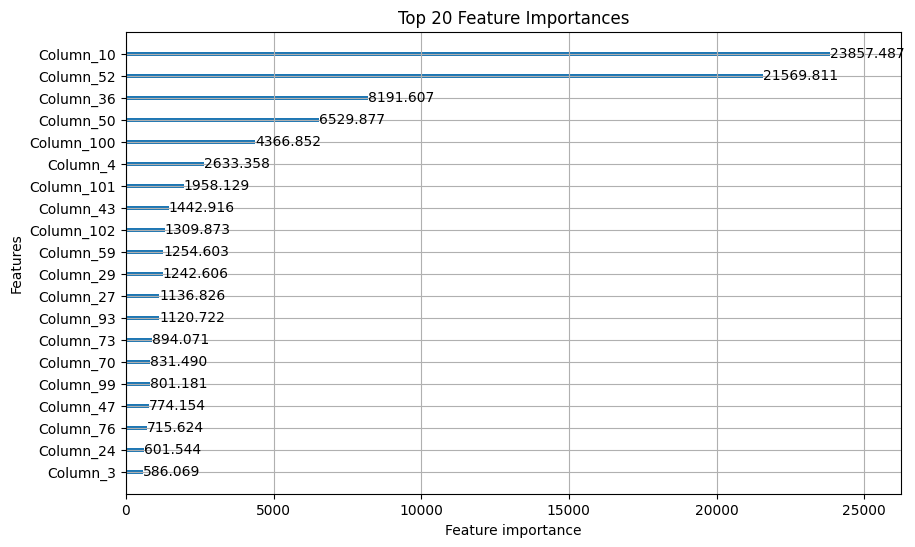

Sample submission file 'luisparadela7.csv' generated successfully!


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor, plot_importance, early_stopping
from scipy.stats import spearmanr
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- Word2Vec Training ---
# Tokenize text
train_sentences = train_data["text"].apply(lambda x: x.split())
val_sentences = val_data["text"].apply(lambda x: x.split())
test_sentences = test_data["text"].apply(lambda x: x.split())

# Train Word2Vec on training sentences
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Generate sentence embeddings
def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))  # Handle empty sentences
    return np.array(embeddings)

# Generate embeddings for train, validation, and test sets
X_train_embeddings = get_sentence_embedding(train_sentences, word2vec_model, vector_size=100)
y_train = train_data["score"]

X_val_embeddings = get_sentence_embedding(val_sentences, word2vec_model, vector_size=100)
y_val = val_data["score"]

X_test_embeddings = get_sentence_embedding(test_sentences, word2vec_model, vector_size=100)

# --- Feature Engineering ---
def extract_features(df):
    df["sentence_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    df["avg_word_length"] = df["text"].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df["punctuation_count"] = df["text"].str.count(r"[^\w\s]")
    df["type_token_ratio"] = df["text"].apply(lambda x: len(set(x.split())) / (len(x.split()) + 1e-5))
    return df[["sentence_length", "word_count", "avg_word_length", "punctuation_count", "type_token_ratio"]]

# Combine embeddings with additional features
X_train_features = extract_features(train_data).values
X_val_features = extract_features(val_data).values
X_test_features = extract_features(test_data).values

X_train = np.hstack((X_train_embeddings, X_train_features))
X_val = np.hstack((X_val_embeddings, X_val_features))
X_test = np.hstack((X_test_embeddings, X_test_features))

# --- Fine-Tuning with GridSearchCV ---
param_grid = {
    "learning_rate": [0.005, 0.01, 0.02],
    "n_estimators": [300, 400, 500],
    "num_leaves": [15, 20, 25],
    "max_depth": [-1, 5, 10],
    "min_child_samples": [10, 20, 30],
}

# Initialize LightGBM
lgb_model = LGBMRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=spearman_scorer,
    cv=3,
    verbose=10,
    n_jobs=-1
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Best model
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Spearman Correlation:", grid_search.best_score_)

# --- Train Final Model ---
best_model = grid_search.best_estimator_

# Train with callbacks for early stopping
callbacks = [early_stopping(stopping_rounds=50, verbose=True)]
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="rmse", callbacks=callbacks)

# --- Evaluate on Validation Set ---
y_val_pred = best_model.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation:", val_spearman_corr)

# --- Feature Importance ---
plot_importance(best_model, max_num_features=20, importance_type="gain", figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.show()

# --- Generate Predictions for Test Set ---
y_test_pred = best_model.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("luisparadela7.csv", index=False)
print("Sample submission file 'luisparadela7.csv' generated successfully!")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41455
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1176
[LightGBM] [Info] Start training from score 0.520791
Best Parameters: {'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 25}
Best Cross-Validation Spearman Correlation: 0.5590686103261056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41455
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1176
[LightGBM] [Info] Start training from score 0.520791
Training until validation scores don't improve for 50 rounds
Did

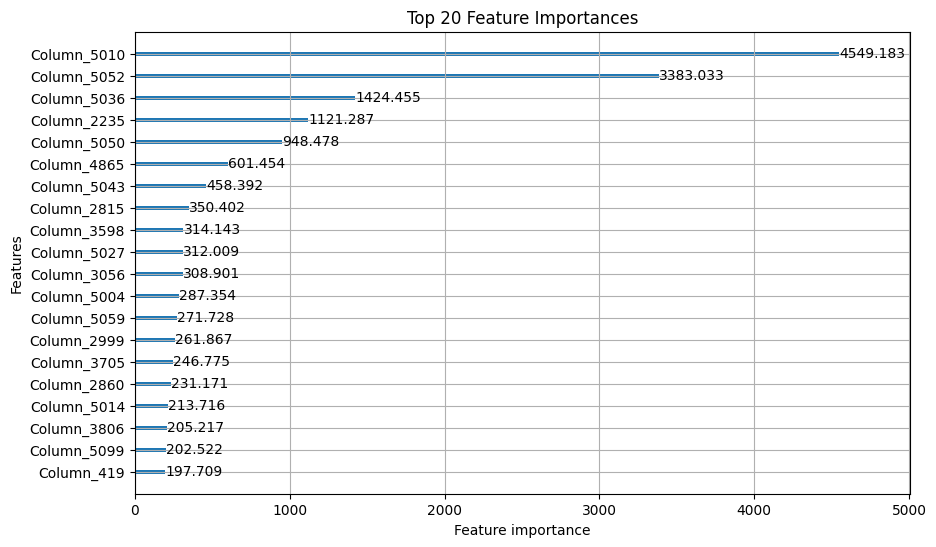

Sample submission file 'takutooshima8.csv' generated successfully!


In [43]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor, plot_importance
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit the number of features
    ngram_range=(1, 2),  # Use unigrams and bigrams
    stop_words="english"  # Remove common stopwords
)

# Fit TF-IDF on the training text
X_train_tfidf = tfidf.fit_transform(train_data["text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["text"]).toarray()

# --- Word2Vec Training ---
train_sentences = train_data["text"].apply(lambda x: x.split())
val_sentences = val_data["text"].apply(lambda x: x.split())
test_sentences = test_data["text"].apply(lambda x: x.split())

# Train Word2Vec on training sentences
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Generate sentence embeddings
def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))  # Handle empty sentences
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_sentences, word2vec_model, vector_size=100)
X_val_word2vec = get_sentence_embedding(val_sentences, word2vec_model, vector_size=100)
X_test_word2vec = get_sentence_embedding(test_sentences, word2vec_model, vector_size=100)

# --- Combine TF-IDF and Word2Vec ---
X_train = np.hstack((X_train_tfidf, X_train_word2vec))
X_val = np.hstack((X_val_tfidf, X_val_word2vec))
X_test = np.hstack((X_test_tfidf, X_test_word2vec))
y_train = train_data["score"]
y_val = val_data["score"]

# --- LightGBM Model ---
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 400, 500],
    "num_leaves": [20, 25, 30],
    "max_depth": [-1, 5, 10],
    "min_child_samples": [10, 20, 30],
}

lgb_model = LGBMRegressor(random_state=42)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=spearman_scorer,
    cv=3,
    verbose=10,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Spearman Correlation:", grid_search.best_score_)

# Train final model
best_model = grid_search.best_estimator_
callbacks = [early_stopping(stopping_rounds=50, verbose=True)]
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="rmse", callbacks=callbacks)

# --- Evaluate on Validation Set ---
y_val_pred = best_model.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation:", val_spearman_corr)

# --- Feature Importance ---
plot_importance(best_model, max_num_features=20, importance_type="gain", figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.show()

# --- Generate Predictions for Test Set ---
y_test_pred = best_model.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("takutooshima8.csv", index=False)
print("Sample submission file 'takutooshima8.csv' generated successfully!")


In [52]:
!pip install --upgrade xgboost


In [54]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor, early_stopping
import xgboost as xgb
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import VotingRegressor

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Preprocessing ---
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["cleaned_text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["cleaned_text"]).toarray()

# --- Word2Vec Training ---
train_sentences = train_data["cleaned_text"].apply(lambda x: x.split())
val_sentences = val_data["cleaned_text"].apply(lambda x: x.split())
test_sentences = test_data["cleaned_text"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_sentences, word2vec_model, vector_size=100)
X_val_word2vec = get_sentence_embedding(val_sentences, word2vec_model, vector_size=100)
X_test_word2vec = get_sentence_embedding(test_sentences, word2vec_model, vector_size=100)

# --- Combine Features ---
X_train = np.hstack((X_train_tfidf, X_train_word2vec))
X_val = np.hstack((X_val_tfidf, X_val_word2vec))
X_test = np.hstack((X_test_tfidf, X_test_word2vec))
y_train = train_data["score"]
y_val = val_data["score"]

# --- LightGBM ---
lgb_model = LGBMRegressor(n_estimators=400, learning_rate=0.01, max_depth=-1, num_leaves=25, random_state=42)
lgb_callbacks = [early_stopping(stopping_rounds=50, verbose=True)]
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="rmse", callbacks=lgb_callbacks)

# --- XGBoost with DMatrix ---
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.01,
    "max_depth": 6,
    "seed": 42,
}

xgb_booster = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=400,
    evals=[(dval, "validation")],
    early_stopping_rounds=50,
    verbose_eval=10
)

# --- Generate Predictions for Test Set ---
xgb_model = xgb.XGBRegressor(**xgb_params, n_estimators=xgb_booster.best_iteration)

# --- Ensemble with Voting Regressor ---
ensemble = VotingRegressor([('lightgbm', lgb_model), ('xgboost', xgb_model)])
ensemble.fit(X_train, y_train)

# --- Evaluate on Validation Set ---
y_val_pred = ensemble.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation (Ensemble):", val_spearman_corr)

# --- Generate Predictions for Test Set ---
y_test_pred = ensemble.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("vladimirscreciu6.csv", index=False)
print("Sample submission file 'vladimirscreciu6.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38137
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 615
[LightGBM] [Info] Start training from score 0.520791
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[399]	valid_0's rmse: 0.670495	valid_0's l2: 0.449563
[0]	validation-rmse:0.81379
[10]	validation-rmse:0.79724
[20]	validation-rmse:0.78368
[30]	validation-rmse:0.77225
[40]	validation-rmse:0.76088
[50]	validation-rmse:0.75114
[60]	validation-rmse:0.74358
[70]	validation-rmse:0.73619
[80]	validation-rmse:0.73016
[90]	validation-rmse:0.72512
[100]	validation-rmse:0.72061
[110]	validation-rmse:0.71648
[120]	validation-rmse:0.71290
[130]	validation-rmse:0.71019
[140]	validation-rmse:0.70770
[150]	validation-rmse:0.70574
[160]	validation-rmse:0.7

In [55]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Preprocessing ---
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["cleaned_text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["cleaned_text"]).toarray()

# --- Word2Vec Training ---
train_sentences = train_data["cleaned_text"].apply(lambda x: x.split())
val_sentences = val_data["cleaned_text"].apply(lambda x: x.split())
test_sentences = test_data["cleaned_text"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_sentences, word2vec_model, vector_size=100)
X_val_word2vec = get_sentence_embedding(val_sentences, word2vec_model, vector_size=100)
X_test_word2vec = get_sentence_embedding(test_sentences, word2vec_model, vector_size=100)

# --- Combine Features ---
X_train = np.hstack((X_train_tfidf, X_train_word2vec))
X_val = np.hstack((X_val_tfidf, X_val_word2vec))
X_test = np.hstack((X_test_tfidf, X_test_word2vec))
y_train = train_data["score"]
y_val = val_data["score"]

# --- Hyperparameter Tuning for XGBoost ---
param_dist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 6, 10],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [0.5, 1, 2],
}

xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=make_scorer(spearman_correlation),
    cv=3,
    verbose=10,
    random_state=42,
    n_jobs=-1,
)

random_search.fit(X_train, y_train)

# Best Parameters and Model
best_xgb_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Spearman Correlation:", random_search.best_score_)

# --- Evaluate on Validation Set ---
y_val_pred = best_xgb_model.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation (XGBoost):", val_spearman_corr)

# --- Generate Predictions for Test Set ---
y_test_pred = best_xgb_model.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("stefanvladoiu2.csv", index=False)
print("Sample submission file 'stefanvladoiu2.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\xgboost\sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File 

Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Best Cross-Validation Spearman Correlation: 0.5563371560940552
Validation Spearman Correlation (XGBoost): 0.5786603943358029
Sample submission file 'stefanvladoiu2.csv' generated successfully!


In [57]:
!pip install optuna

   ---------------------------------------- 0.0/364.4 kB ? eta -:--:--
   -------- ------------------------------- 81.9/364.4 kB 1.5 MB/s eta 0:00:01
   ------------------------------ --------- 276.5/364.4 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 364.4/364.4 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.5 kB ? eta -:--:--
   ---------------------------------------- 233.5/233.5 kB ? eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB 5.6 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.1 MB 11.1 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 16.6 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 14.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/298.4 kB ? eta -:--:--
   --------------------------------------- 298.4/298.4 kB 19.2 MB/s eta 0:00:00
   ----------------

In [59]:
!pip install optuna-integration[xgboost]

   ---------------------------------------- 0.0/97.4 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/97.4 kB ? eta -:--:--
   ------------------------- -------------- 61.4/97.4 kB 825.8 kB/s eta 0:00:01
   ---------------------------------------- 97.4/97.4 kB 937.6 kB/s eta 0:00:00


In [61]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords
import optuna

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Preprocessing ---
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["cleaned_text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["cleaned_text"]).toarray()

# --- Word2Vec Training ---
train_sentences = train_data["cleaned_text"].apply(lambda x: x.split())
val_sentences = val_data["cleaned_text"].apply(lambda x: x.split())
test_sentences = test_data["cleaned_text"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_sentences, word2vec_model, vector_size=100)
X_val_word2vec = get_sentence_embedding(val_sentences, word2vec_model, vector_size=100)
X_test_word2vec = get_sentence_embedding(test_sentences, word2vec_model, vector_size=100)

# --- Combine Features ---
X_train = np.hstack((X_train_tfidf, X_train_word2vec))
X_val = np.hstack((X_val_tfidf, X_val_word2vec))
X_test = np.hstack((X_test_tfidf, X_test_word2vec))
y_train = train_data["score"]
y_val = val_data["score"]

# --- RandomizedSearchCV for Hyperparameter Tuning ---
param_dist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "min_child_weight": [1, 2, 3],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2],
    "n_estimators": [100, 200, 300],
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=make_scorer(spearman_correlation),
    cv=3,
    verbose=10,
    random_state=42,
    n_jobs=-1,
)

random_search.fit(X_train, y_train)
best_xgb_model_random = random_search.best_estimator_
print("RandomizedSearch Best Parameters:", random_search.best_params_)
print("RandomizedSearch Best CV Spearman Correlation:", random_search.best_score_)

# --- Optuna for Bayesian Optimization ---
def objective(trial):
    param = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "subsample": trial.suggest_uniform("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 0.9),
        "gamma": trial.suggest_uniform("gamma", 0, 0.3),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 1),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 0.1, 2),
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    evals = [(dval, "validation")]
    model = xgb.train(param, dtrain, num_boost_round=300, evals=evals, early_stopping_rounds=50, verbose_eval=False)
    preds = model.predict(dval)
    return spearman_correlation(y_val, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Optuna Best Parameters:", study.best_params)

# --- Train Best Model from Optuna ---
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
best_params = study.best_params
xgb_optuna_model = xgb.train(best_params, dtrain, num_boost_round=300, evals=[(dval, "validation")])

# --- Evaluate on Validation Set ---
y_val_pred_optuna = xgb_optuna_model.predict(dval)
val_spearman_corr_optuna = spearman_correlation(y_val, y_val_pred_optuna)
print("Validation Spearman Correlation (Optuna):", val_spearman_corr_optuna)

# --- Generate Predictions for Test Set ---
dtest = xgb.DMatrix(X_test)
y_test_pred = xgb_optuna_model.predict(dtest)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("basiliondong12.csv", index=False)
print("Sample submission file 'basiliondong12.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[I 2024-12-03 03:03:48,752] A new study created in memory with name: no-name-8b7c34cb-47d6-46a2-8a6b-ca35c39a3c49


RandomizedSearch Best Parameters: {'subsample': 0.7, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
RandomizedSearch Best CV Spearman Correlation: 0.5517844442063895


C:\Users\RoG\AppData\Local\Temp\ipykernel_14836\1783825230.py:114: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
C:\Users\RoG\AppData\Local\Temp\ipykernel_14836\1783825230.py:117: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 0.9),
C:\Users\RoG\AppData\Local\Temp\ipykernel_14836\1783825230.py:118: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 0.9),
C:\Users\Ro

Optuna Best Parameters: {'learning_rate': 0.02158439998229514, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8646222418787073, 'colsample_bytree': 0.6010030629301368, 'gamma': 0.17244768552409692, 'reg_alpha': 0.22505033233934946, 'reg_lambda': 0.7751465862335809}
[0]	validation-rmse:0.81146
[1]	validation-rmse:0.80691
[2]	validation-rmse:0.80306
[3]	validation-rmse:0.79933
[4]	validation-rmse:0.79585
[5]	validation-rmse:0.79240
[6]	validation-rmse:0.78905
[7]	validation-rmse:0.78534
[8]	validation-rmse:0.78206
[9]	validation-rmse:0.77875
[10]	validation-rmse:0.77597
[11]	validation-rmse:0.77321
[12]	validation-rmse:0.77048
[13]	validation-rmse:0.76804
[14]	validation-rmse:0.76546
[15]	validation-rmse:0.76318
[16]	validation-rmse:0.76058
[17]	validation-rmse:0.75798
[18]	validation-rmse:0.75560
[19]	validation-rmse:0.75308
[20]	validation-rmse:0.75086
[21]	validation-rmse:0.74850
[22]	validation-rmse:0.74601
[23]	validation-rmse:0.74409
[24]	validation-rmse:0.74189
[25]	validat

In [62]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Preprocessing ---
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["cleaned_text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["cleaned_text"]).toarray()

# --- Word2Vec Training ---
train_sentences = train_data["cleaned_text"].apply(lambda x: x.split())
val_sentences = val_data["cleaned_text"].apply(lambda x: x.split())
test_sentences = test_data["cleaned_text"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_sentences, word2vec_model, vector_size=100)
X_val_word2vec = get_sentence_embedding(val_sentences, word2vec_model, vector_size=100)
X_test_word2vec = get_sentence_embedding(test_sentences, word2vec_model, vector_size=100)

# --- Combine Features ---
X_train = np.hstack((X_train_tfidf, X_train_word2vec))
X_val = np.hstack((X_val_tfidf, X_val_word2vec))
X_test = np.hstack((X_test_tfidf, X_test_word2vec))
y_train = train_data["score"]
y_val = val_data["score"]

# --- Grid Search for Hyperparameter Tuning ---
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "min_child_weight": [1, 2, 3],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "n_estimators": [100, 200, 300],
}

xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=make_scorer(spearman_correlation),
    cv=3,
    verbose=10,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

# Best Parameters and Model
best_xgb_model = grid_search.best_estimator_
print("GridSearch Best Parameters:", grid_search.best_params_)
print("GridSearch Best CV Spearman Correlation:", grid_search.best_score_)

# --- Evaluate on Validation Set ---
y_val_pred = best_xgb_model.predict(X_val)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation (GridSearch):", val_spearman_corr)

# --- Generate Predictions for Test Set ---
y_test_pred = best_xgb_model.predict(X_test)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("lyeshouri14.csv", index=False)
print("Sample submission file 'lyeshouri14.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 2187.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\RoG\anaconda3\envs\licenta\lib\site-packages\xgboost\sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File

GridSearch Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}
GridSearch Best CV Spearman Correlation: 0.5565226599136056
Validation Spearman Correlation (GridSearch): 0.5611624821407921
Sample submission file 'lyeshouri14.csv' generated successfully!


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Preprocessing ---
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["cleaned_text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["cleaned_text"]).toarray()

# --- Word2Vec Training ---
train_sentences = train_data["cleaned_text"].apply(lambda x: x.split())
val_sentences = val_data["cleaned_text"].apply(lambda x: x.split())
test_sentences = test_data["cleaned_text"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_sentences, word2vec_model, vector_size=100)
X_val_word2vec = get_sentence_embedding(val_sentences, word2vec_model, vector_size=100)
X_test_word2vec = get_sentence_embedding(test_sentences, word2vec_model, vector_size=100)

# --- Target Variable ---
y_train = train_data["score"]
y_val = val_data["score"]

# --- Ridge Regression with TF-IDF + Word2Vec ---
print("Training Ridge Regression with TF-IDF + Word2Vec Features...")
X_train_combined = np.hstack((X_train_tfidf, X_train_word2vec))
X_val_combined = np.hstack((X_val_tfidf, X_val_word2vec))
X_test_combined = np.hstack((X_test_tfidf, X_test_word2vec))

ridge_model_combined = Ridge()
ridge_model_combined.fit(X_train_combined, y_train)

# Evaluate on Validation Set
y_val_pred_combined = ridge_model_combined.predict(X_val_combined)
val_spearman_corr_combined = spearman_correlation(y_val, y_val_pred_combined)
print("Validation Spearman Correlation (TF-IDF + Word2Vec + Ridge):", val_spearman_corr_combined)

# Generate Predictions for Test Set
y_test_pred_combined = ridge_model_combined.predict(X_test_combined)

# Create Sample Submission
submission_combined = pd.DataFrame({"id": test_data["id"], "score": y_test_pred_combined})
submission_combined.to_csv("silviulungjr33.csv", index=False)
print("Sample submission file 'submission_ridge_tfidf_word2vec.csv' generated successfully!")

# --- Ridge Regression with Word2Vec Only ---
print("\nTraining Ridge Regression with Word2Vec Features Only...")
ridge_model_word2vec = Ridge()
ridge_model_word2vec.fit(X_train_word2vec, y_train)

# Evaluate on Validation Set
y_val_pred_word2vec = ridge_model_word2vec.predict(X_val_word2vec)
val_spearman_corr_word2vec = spearman_correlation(y_val, y_val_pred_word2vec)
print("Validation Spearman Correlation (Word2Vec + Ridge):", val_spearman_corr_word2vec)

# Generate Predictions for Test Set
y_test_pred_word2vec = ridge_model_word2vec.predict(X_test_word2vec)

# Create Sample Submission
submission_word2vec = pd.DataFrame({"id": test_data["id"], "score": y_test_pred_word2vec})
submission_word2vec.to_csv("relustoian32.csv", index=False)
print("Sample submission file 'submission_ridge_word2vec.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training Ridge Regression with TF-IDF + Word2Vec Features...
Validation Spearman Correlation (TF-IDF + Word2Vec + Ridge): 0.5849440402791134
Sample submission file 'submission_ridge_tfidf_word2vec.csv' generated successfully!

Training Ridge Regression with Word2Vec Features Only...
Validation Spearman Correlation (Word2Vec + Ridge): 0.5087024394610922
Sample submission file 'submission_ridge_word2vec.csv' generated successfully!


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Preprocessing ---
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["cleaned_text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["cleaned_text"]).toarray()

# --- Dimensionality Reduction for TF-IDF ---
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_val_tfidf_reduced = svd.transform(X_val_tfidf)
X_test_tfidf_reduced = svd.transform(X_test_tfidf)

# --- Word2Vec Training ---
train_sentences = train_data["cleaned_text"].apply(lambda x: x.split())
val_sentences = val_data["cleaned_text"].apply(lambda x: x.split())
test_sentences = test_data["cleaned_text"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences=train_sentences, vector_size=200, window=5, min_count=1, workers=4)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_sentences, word2vec_model, vector_size=200)
X_val_word2vec = get_sentence_embedding(val_sentences, word2vec_model, vector_size=200)
X_test_word2vec = get_sentence_embedding(test_sentences, word2vec_model, vector_size=200)

# --- Combine Features ---
X_train_combined = np.hstack((X_train_tfidf_reduced, X_train_word2vec))
X_val_combined = np.hstack((X_val_tfidf_reduced, X_val_word2vec))
X_test_combined = np.hstack((X_test_tfidf_reduced, X_test_word2vec))

# Normalize Features
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_val_combined = scaler.transform(X_val_combined)
X_test_combined = scaler.transform(X_test_combined)

# --- Target Variable ---
y_train = train_data["score"]
y_val = val_data["score"]

# --- Ridge Regression with Hyperparameter Tuning ---
param_grid = {
    "alpha": [0.01, 0.1, 1, 10, 100],  # Regularization strength
}

ridge_model = Ridge()

grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    scoring=make_scorer(spearman_correlation),
    cv=3,
    verbose=10,
    n_jobs=-1,
)

grid_search.fit(X_train_combined, y_train)

# Best Parameters and Model
best_ridge_model = grid_search.best_estimator_
print("Best Ridge Parameters:", grid_search.best_params_)
print("Best Cross-Validation Spearman Correlation:", grid_search.best_score_)

# --- Evaluate on Validation Set ---
y_val_pred_combined = best_ridge_model.predict(X_val_combined)
val_spearman_corr_combined = spearman_correlation(y_val, y_val_pred_combined)
print("Validation Spearman Correlation (Improved Ridge):", val_spearman_corr_combined)

# --- Generate Predictions for Test Set ---
y_test_pred_combined = best_ridge_model.predict(X_test_combined)

# --- Create Sample Submission ---
submission_combined = pd.DataFrame({"id": test_data["id"], "score": y_test_pred_combined})
submission_combined.to_csv("stefanbana31.csv", index=False)
print("Sample submission file 'submission_ridge_improved.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Ridge Parameters: {'alpha': 100}
Best Cross-Validation Spearman Correlation: 0.5791215569765563
Validation Spearman Correlation (Improved Ridge): 0.6020660564040241
Sample submission file 'submission_ridge_improved.csv' generated successfully!


In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Preprocessing ---
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# --- Additional Sentence Features ---
def extract_sentence_features(df):
    df["sentence_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    df["punctuation_count"] = df["text"].str.count(r'[^\w\s]')
    return df[["sentence_length", "word_count", "punctuation_count"]]

train_sentence_features = extract_sentence_features(train_data)
val_sentence_features = extract_sentence_features(val_data)
test_sentence_features = extract_sentence_features(test_data)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(
    max_features=10000,  # Increased size
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["cleaned_text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["cleaned_text"]).toarray()

# --- Dimensionality Reduction for TF-IDF ---
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_val_tfidf_reduced = svd.transform(X_val_tfidf)
X_test_tfidf_reduced = svd.transform(X_test_tfidf)

# --- Word2Vec Training ---
train_sentences = train_data["cleaned_text"].apply(lambda x: x.split())
val_sentences = val_data["cleaned_text"].apply(lambda x: x.split())
test_sentences = test_data["cleaned_text"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences=train_sentences, vector_size=300, window=10, min_count=1, workers=4, epochs=20)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_sentences, word2vec_model, vector_size=300)
X_val_word2vec = get_sentence_embedding(val_sentences, word2vec_model, vector_size=300)
X_test_word2vec = get_sentence_embedding(test_sentences, word2vec_model, vector_size=300)

# --- Polynomial Features ---
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_word2vec)
X_val_poly = poly.transform(X_val_word2vec)
X_test_poly = poly.transform(X_test_word2vec)

# --- Combine Features ---
X_train_combined = np.hstack((X_train_tfidf_reduced, X_train_word2vec, train_sentence_features.values))
X_val_combined = np.hstack((X_val_tfidf_reduced, X_val_word2vec, val_sentence_features.values))
X_test_combined = np.hstack((X_test_tfidf_reduced, X_test_word2vec, test_sentence_features.values))

# Normalize Features
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_val_combined = scaler.transform(X_val_combined)
X_test_combined = scaler.transform(X_test_combined)

# --- Target Variable ---
y_train = train_data["score"]
y_val = val_data["score"]

# --- Ridge Regression with Hyperparameter Tuning ---
param_grid = {
    "alpha": [0.01, 0.1, 1, 10, 100, 500],  # Expanded range
}

ridge_model = Ridge()

grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    scoring=make_scorer(spearman_correlation),
    cv=5,  # Increased folds for stability
    verbose=10,
    n_jobs=-1,
)

grid_search.fit(X_train_combined, y_train)

# Best Parameters and Model
best_ridge_model = grid_search.best_estimator_
print("Best Ridge Parameters:", grid_search.best_params_)
print("Best Cross-Validation Spearman Correlation:", grid_search.best_score_)

# --- Evaluate on Validation Set ---
y_val_pred_combined = best_ridge_model.predict(X_val_combined)
val_spearman_corr_combined = spearman_correlation(y_val, y_val_pred_combined)
print("Validation Spearman Correlation (Improved Ridge):", val_spearman_corr_combined)

# --- Generate Predictions for Test Set ---
y_test_pred_combined = best_ridge_model.predict(X_test_combined)

# --- Create Sample Submission ---
submission_combined = pd.DataFrame({"id": test_data["id"], "score": y_test_pred_combined})
submission_combined.to_csv("mariandanciu37.csv", index=False)
print("Sample submission file 'submission_ridge_improved.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Ridge Parameters: {'alpha': 500}
Best Cross-Validation Spearman Correlation: 0.588936667929304
Validation Spearman Correlation (Improved Ridge): 0.605014086634251
Sample submission file 'submission_ridge_improved.csv' generated successfully!


In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")  # Format: id, text, score
val_data = pd.read_csv("val.csv")      # Format: id, text, score
test_data = pd.read_csv("test.csv")    # Format: id, text

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Preprocessing ---
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# --- Additional Sentence Features ---
def extract_sentence_features(df):
    df["sentence_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    df["punctuation_count"] = df["text"].str.count(r'[^\w\s]')
    return df[["sentence_length", "word_count", "punctuation_count"]]

train_sentence_features = extract_sentence_features(train_data)
val_sentence_features = extract_sentence_features(val_data)
test_sentence_features = extract_sentence_features(test_data)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(
    max_features=10000,  # Larger size for richer features
    ngram_range=(1, 3),  # Increased n-gram range
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["cleaned_text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["cleaned_text"]).toarray()

# --- Dimensionality Reduction for TF-IDF ---
svd = TruncatedSVD(n_components=500, random_state=42)  # Reduce TF-IDF to 500 dimensions
X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_val_tfidf_reduced = svd.transform(X_val_tfidf)
X_test_tfidf_reduced = svd.transform(X_test_tfidf)

# --- Word2Vec Training ---
train_sentences = train_data["cleaned_text"].apply(lambda x: x.split())
val_sentences = val_data["cleaned_text"].apply(lambda x: x.split())
test_sentences = test_data["cleaned_text"].apply(lambda x: x.split())

word2vec_model = Word2Vec(
    sentences=train_sentences, 
    vector_size=300,  # Larger vector size
    window=10,  # Wider context
    min_count=1, 
    workers=4, 
    epochs=20  # Increased epochs for better embeddings
)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_sentences, word2vec_model, vector_size=300)
X_val_word2vec = get_sentence_embedding(val_sentences, word2vec_model, vector_size=300)
X_test_word2vec = get_sentence_embedding(test_sentences, word2vec_model, vector_size=300)

# --- Dimensionality Reduction for Word2Vec ---
svd_word2vec = TruncatedSVD(n_components=50, random_state=42)  # Reduce Word2Vec to 50 dimensions
X_train_word2vec_reduced = svd_word2vec.fit_transform(X_train_word2vec)
X_val_word2vec_reduced = svd_word2vec.transform(X_val_word2vec)
X_test_word2vec_reduced = svd_word2vec.transform(X_test_word2vec)

# --- Polynomial Features on Reduced Word2Vec ---
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)  # Reduced degree
X_train_poly = poly.fit_transform(X_train_word2vec_reduced)
X_val_poly = poly.transform(X_val_word2vec_reduced)
X_test_poly = poly.transform(X_test_word2vec_reduced)

# --- Combine Features ---
X_train_combined = np.hstack((X_train_tfidf_reduced, X_train_poly, train_sentence_features.values))
X_val_combined = np.hstack((X_val_tfidf_reduced, X_val_poly, val_sentence_features.values))
X_test_combined = np.hstack((X_test_tfidf_reduced, X_test_poly, test_sentence_features.values))

# Normalize Features
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_val_combined = scaler.transform(X_val_combined)
X_test_combined = scaler.transform(X_test_combined)

# --- Target Variable ---
y_train = train_data["score"]
y_val = val_data["score"]

# --- Ridge Regression with Hyperparameter Tuning ---
param_grid = {
    "alpha": np.logspace(-2, 3, 10)  # Expanded range with finer granularity
}

ridge_model = Ridge()

grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    scoring=make_scorer(spearman_correlation),
    cv=5,  # Increased folds for better generalization
    verbose=10,
    n_jobs=-1,
)

grid_search.fit(X_train_combined, y_train)

# Best Parameters and Model
best_ridge_model = grid_search.best_estimator_
print("Best Ridge Parameters:", grid_search.best_params_)
print("Best Cross-Validation Spearman Correlation:", grid_search.best_score_)

# --- Evaluate on Validation Set ---
y_val_pred_combined = best_ridge_model.predict(X_val_combined)
val_spearman_corr_combined = spearman_correlation(y_val, y_val_pred_combined)
print("Validation Spearman Correlation (Improved Ridge):", val_spearman_corr_combined)

# --- Generate Predictions for Test Set ---
y_test_pred_combined = best_ridge_model.predict(X_test_combined)

# --- Create Sample Submission ---
submission_combined = pd.DataFrame({"id": test_data["id"], "score": y_test_pred_combined})
submission_combined.to_csv("davidbarbu27.csv", index=False)
print("Sample submission file 'davidbarbu27.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Ridge Parameters: {'alpha': 1000.0}
Best Cross-Validation Spearman Correlation: 0.5749472848816216
Validation Spearman Correlation (Improved Ridge): 0.5763983917988468
Sample submission file 'davidbarbu27.csv' generated successfully!


In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Preprocessing ---
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# --- Additional Sentence Features ---
def extract_sentence_features(df):
    df["sentence_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    df["punctuation_count"] = df["text"].str.count(r'[^\w\s]')
    return df[["sentence_length", "word_count", "punctuation_count"]]

train_sentence_features = extract_sentence_features(train_data)
val_sentence_features = extract_sentence_features(val_data)
test_sentence_features = extract_sentence_features(test_data)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["cleaned_text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["cleaned_text"]).toarray()

# --- Dimensionality Reduction for TF-IDF ---
svd_tfidf = TruncatedSVD(n_components=400, random_state=42)
X_train_tfidf_reduced = svd_tfidf.fit_transform(X_train_tfidf)
X_val_tfidf_reduced = svd_tfidf.transform(X_val_tfidf)
X_test_tfidf_reduced = svd_tfidf.transform(X_test_tfidf)

# --- Word2Vec Training ---
train_sentences = train_data["cleaned_text"].apply(lambda x: x.split())
val_sentences = val_data["cleaned_text"].apply(lambda x: x.split())
test_sentences = test_data["cleaned_text"].apply(lambda x: x.split())

word2vec_model = Word2Vec(
    sentences=train_sentences,
    vector_size=400,
    window=10,
    min_count=1,
    workers=4,
    epochs=30
)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_sentences, word2vec_model, vector_size=400)
X_val_word2vec = get_sentence_embedding(val_sentences, word2vec_model, vector_size=400)
X_test_word2vec = get_sentence_embedding(test_sentences, word2vec_model, vector_size=400)

# --- Dimensionality Reduction for Word2Vec ---
svd_word2vec = TruncatedSVD(n_components=100, random_state=42)
X_train_word2vec_reduced = svd_word2vec.fit_transform(X_train_word2vec)
X_val_word2vec_reduced = svd_word2vec.transform(X_val_word2vec)
X_test_word2vec_reduced = svd_word2vec.transform(X_test_word2vec)

# --- Polynomial Features on Reduced Word2Vec ---
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_word2vec_reduced)
X_val_poly = poly.transform(X_val_word2vec_reduced)
X_test_poly = poly.transform(X_test_word2vec_reduced)

# --- Combine Features ---
X_train_combined = np.hstack((X_train_tfidf_reduced, X_train_poly, train_sentence_features.values))
X_val_combined = np.hstack((X_val_tfidf_reduced, X_val_poly, val_sentence_features.values))
X_test_combined = np.hstack((X_test_tfidf_reduced, X_test_poly, test_sentence_features.values))

# Normalize Features
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_val_combined = scaler.transform(X_val_combined)
X_test_combined = scaler.transform(X_test_combined)

# --- Target Variable ---
y_train = train_data["score"]
y_val = val_data["score"]

# --- Ridge Regression with Hyperparameter Tuning ---
param_grid = {
    "alpha": np.logspace(-2, 3, 15)
}

ridge_model = Ridge()

grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    scoring=make_scorer(spearman_correlation),
    cv=10,
    verbose=10,
    n_jobs=-1,
)

grid_search.fit(X_train_combined, y_train)

# Best Parameters and Model
best_ridge_model = grid_search.best_estimator_
print("Best Ridge Parameters:", grid_search.best_params_)
print("Best Cross-Validation Spearman Correlation:", grid_search.best_score_)

# --- Evaluate on Validation Set ---
y_val_pred_combined = best_ridge_model.predict(X_val_combined)
val_spearman_corr_combined = spearman_correlation(y_val, y_val_pred_combined)
print("Validation Spearman Correlation (Improved Ridge):", val_spearman_corr_combined)

# --- Generate Predictions for Test Set ---
y_test_pred_combined = best_ridge_model.predict(X_test_combined)

# --- Create Sample Submission ---
submission_combined = pd.DataFrame({"id": test_data["id"], "score": y_test_pred_combined})
submission_combined.to_csv("jurajbadelj15.csv", index=False)
print("Sample submission file 'submission_ridge_optimized.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best Ridge Parameters: {'alpha': 1000.0}
Best Cross-Validation Spearman Correlation: 0.49722463175314013
Validation Spearman Correlation (Improved Ridge): 0.46857148077465377
Sample submission file 'submission_ridge_optimized.csv' generated successfully!


In [12]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# --- Preprocessing ---
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join(stemmer.stem(word) for word in text.split() if word not in stop_words)  # Stemming and stopwords
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# Combine Training and Validation Data for Word2Vec
combined_sentences = pd.concat([train_data["cleaned_text"], val_data["cleaned_text"]]).apply(lambda x: x.split())

# --- Word2Vec Training ---
word2vec_model = Word2Vec(
    sentences=combined_sentences,
    vector_size=400,  # Larger vector size
    window=8,  # Adjusted window size
    min_count=2,  # Further filter rare words
    workers=8,  # Utilize maximum parallelism
    epochs=300,  # Further increased epochs
    sg=1,  # Skip-gram model
    negative=15  # Negative sampling
)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_data["cleaned_text"].apply(lambda x: x.split()), word2vec_model, vector_size=400)
X_val_word2vec = get_sentence_embedding(val_data["cleaned_text"].apply(lambda x: x.split()), word2vec_model, vector_size=400)
X_test_word2vec = get_sentence_embedding(test_data["cleaned_text"].apply(lambda x: x.split()), word2vec_model, vector_size=400)

# --- Additional Features ---
def extract_features(df):
    df["sentence_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    df["punctuation_count"] = df["text"].str.count(r'[^\w\s]')
    return df[["sentence_length", "word_count", "punctuation_count"]]

train_features = extract_features(train_data)
val_features = extract_features(val_data)
test_features = extract_features(test_data)

# --- Dimensionality Reduction ---
svd = TruncatedSVD(n_components=250, random_state=42)  # Experimenting with increased dimensions
X_train_reduced = svd.fit_transform(X_train_word2vec)
X_val_reduced = svd.transform(X_val_word2vec)
X_test_reduced = svd.transform(X_test_word2vec)

# Combine Word2Vec and Handcrafted Features
X_train_combined = np.hstack((X_train_reduced, train_features.values))
X_val_combined = np.hstack((X_val_reduced, val_features.values))
X_test_combined = np.hstack((X_test_reduced, test_features.values))

# Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)
X_test_scaled = scaler.transform(X_test_combined)

# --- Target Variable ---
y_train = train_data["score"]
y_val = val_data["score"]

# --- Ridge Regression with Extensive Hyperparameter Tuning ---
param_grid = {
    "alpha": np.logspace(-5, 5, 80)  # Expanded range with finer granularity
}

ridge_model = Ridge()

grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    scoring=make_scorer(spearman_correlation),
    cv=50,  # Further increased folds for stability
    verbose=10,
    n_jobs=-1,
)

grid_search.fit(X_train_scaled, y_train)

# Best Parameters and Model
best_ridge_model = grid_search.best_estimator_
print("Best Ridge Parameters:", grid_search.best_params_)
print("Best Cross-Validation Spearman Correlation:", grid_search.best_score_)

# --- Evaluate on Validation Set ---
y_val_pred = best_ridge_model.predict(X_val_scaled)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation (Optimized Ridge):", val_spearman_corr)

# --- Generate Predictions for Test Set ---
y_test_pred = best_ridge_model.predict(X_test_scaled)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("gjokozajkov26.csv", index=False)
print("Sample submission file 'submission_word2vec_ridge_advanced.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 50 folds for each of 80 candidates, totalling 4000 fits
Best Ridge Parameters: {'alpha': 1689.849786812462}
Best Cross-Validation Spearman Correlation: 0.5768633211688421
Validation Spearman Correlation (Optimized Ridge): 0.5756855052752906
Sample submission file 'submission_word2vec_ridge_advanced.csv' generated successfully!


In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- Preprocessing ---
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join(stemmer.stem(word) for word in text.split() if word not in stop_words)  # Stemming and stopwords
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# Combine Training and Validation Data for Word2Vec
combined_sentences = pd.concat([train_data["cleaned_text"], val_data["cleaned_text"]]).apply(lambda x: x.split())

# --- Word2Vec Training ---
word2vec_model = Word2Vec(
    sentences=combined_sentences,
    vector_size=400,  # Larger vector size
    window=8,  # Adjusted window size
    min_count=2,  # Further filter rare words
    workers=8,  # Utilize maximum parallelism
    epochs=200,  # Increased epochs
    sg=1,  # Skip-gram model
    negative=10  # Negative sampling
)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_data["cleaned_text"].apply(lambda x: x.split()), word2vec_model, vector_size=400)
X_val_word2vec = get_sentence_embedding(val_data["cleaned_text"].apply(lambda x: x.split()), word2vec_model, vector_size=400)
X_test_word2vec = get_sentence_embedding(test_data["cleaned_text"].apply(lambda x: x.split()), word2vec_model, vector_size=400)

# --- Dimensionality Reduction ---
svd = TruncatedSVD(n_components=200, random_state=42)  # Experimenting with increased dimensions
X_train_reduced = svd.fit_transform(X_train_word2vec)
X_val_reduced = svd.transform(X_val_word2vec)
X_test_reduced = svd.transform(X_test_word2vec)

# Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_val_scaled = scaler.transform(X_val_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# --- Target Variable ---
y_train = train_data["score"]
y_val = val_data["score"]

# --- Ridge Regression ---
ridge_param_grid = {"alpha": np.logspace(-5, 5, 50)}
ridge = Ridge()

ridge_grid = GridSearchCV(
    estimator=ridge,
    param_grid=ridge_param_grid,
    scoring=spearman_scorer,
    cv=10,  # 10-fold CV
    verbose=10,
    n_jobs=-1,
)
ridge_grid.fit(X_train_scaled, y_train)
ridge_best = ridge_grid.best_estimator_
print("Best Ridge Parameters:", ridge_grid.best_params_)
print("Best Ridge Spearman CV Score:", ridge_grid.best_score_)

# --- LightGBM ---
lgbm_param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 500, 1000],
    "max_depth": [-1, 5, 10],
    "num_leaves": [20, 31, 50]
}
lgbm = LGBMRegressor()

lgbm_grid = GridSearchCV(
    estimator=lgbm,
    param_grid=lgbm_param_grid,
    scoring=spearman_scorer,
    cv=10,
    verbose=10,
    n_jobs=-1,
)
lgbm_grid.fit(X_train_scaled, y_train)
lgbm_best = lgbm_grid.best_estimator_
print("Best LightGBM Parameters:", lgbm_grid.best_params_)
print("Best LightGBM Spearman CV Score:", lgbm_grid.best_score_)

# --- XGBoost ---
xgb_param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 500, 1000],
    "max_depth": [3, 6, 10],
    "subsample": [0.6, 0.8, 1.0]
}
xgb = XGBRegressor()

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    scoring=spearman_scorer,
    cv=10,
    verbose=10,
    n_jobs=-1,
)
xgb_grid.fit(X_train_scaled, y_train)
xgb_best = xgb_grid.best_estimator_
print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost Spearman CV Score:", xgb_grid.best_score_)

# --- Ensemble Model ---
ensemble = VotingRegressor([
    ('ridge', ridge_best),
    ('lgbm', lgbm_best),
    ('xgb', xgb_best)
])
ensemble.fit(X_train_scaled, y_train)

# --- Evaluate on Validation Set ---
y_val_pred = ensemble.predict(X_val_scaled)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation (Ensemble):", val_spearman_corr)

# --- Generate Predictions for Test Set ---
y_test_pred = ensemble.predict(X_test_scaled)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("submission_ensemble.csv", index=False)
print("Sample submission file 'submission_ensemble.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Ridge Parameters: {'alpha': 910.2981779915227}
Best Ridge Spearman CV Score: 0.5734762933159474
Fitting 10 folds for each of 81 candidates, totalling 810 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 200
[LightGBM] [Info] Start training from score 0.520791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import spearmanr
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# --- Load Dataset ---
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

# --- Define Spearman Correlation Metric ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- Preprocessing ---
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join(stemmer.stem(word) for word in text.split() if word not in stop_words)  # Stemming and stopwords
    return text

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# Combine Training and Validation Data for Word2Vec
combined_sentences = pd.concat([train_data["cleaned_text"], val_data["cleaned_text"]]).apply(lambda x: x.split())

# --- Word2Vec Training ---
word2vec_model = Word2Vec(
    sentences=combined_sentences,
    vector_size=300,  # Optimized for smaller dataset
    window=5,  # Smaller context window
    min_count=3,
    workers=4,
    epochs=30,  # Reduced epochs
    sg=1,
    negative=10
)

def get_sentence_embedding(sentences, model, vector_size):
    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_data["cleaned_text"].apply(lambda x: x.split()), word2vec_model, vector_size=300)
X_val_word2vec = get_sentence_embedding(val_data["cleaned_text"].apply(lambda x: x.split()), word2vec_model, vector_size=300)
X_test_word2vec = get_sentence_embedding(test_data["cleaned_text"].apply(lambda x: x.split()), word2vec_model, vector_size=300)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))  # Reduced max features
X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"])
X_val_tfidf = tfidf.transform(val_data["cleaned_text"])
X_test_tfidf = tfidf.transform(test_data["cleaned_text"])

# --- Dimensionality Reduction for TF-IDF ---
svd_tfidf = TruncatedSVD(n_components=100, random_state=42)  # Reduced dimensions
X_train_tfidf_reduced = svd_tfidf.fit_transform(X_train_tfidf)
X_val_tfidf_reduced = svd_tfidf.transform(X_val_tfidf)
X_test_tfidf_reduced = svd_tfidf.transform(X_test_tfidf)

# --- Combine Features ---
X_train_combined = np.hstack((X_train_word2vec, X_train_tfidf_reduced))
X_val_combined = np.hstack((X_val_word2vec, X_val_tfidf_reduced))
X_test_combined = np.hstack((X_test_word2vec, X_test_tfidf_reduced))

# Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)
X_test_scaled = scaler.transform(X_test_combined)

# --- Target Variable ---
y_train = train_data["score"]
y_val = val_data["score"]

# --- Ridge Regression ---
ridge_param_grid = {"alpha": [1, 10, 100, 1000]}
ridge = Ridge()

ridge_grid = GridSearchCV(
    estimator=ridge,
    param_grid=ridge_param_grid,
    scoring=spearman_scorer,
    cv=5,
    verbose=10,
    n_jobs=-1,
)
ridge_grid.fit(X_train_scaled, y_train)
ridge_best = ridge_grid.best_estimator_

# --- LightGBM ---
lgbm_param_grid = {
    "learning_rate": [0.05, 0.1],
    "n_estimators": [500, 1000],
    "max_depth": [5, 10],
    "num_leaves": [31, 50]
}
lgbm = LGBMRegressor()

lgbm_grid = GridSearchCV(
    estimator=lgbm,
    param_grid=lgbm_param_grid,
    scoring=spearman_scorer,
    cv=5,
    verbose=10,
    n_jobs=-1,
)
lgbm_grid.fit(X_train_scaled, y_train)
lgbm_best = lgbm_grid.best_estimator_

# --- XGBoost ---
xgb_param_grid = {
    "learning_rate": [0.05, 0.1],
    "n_estimators": [500, 1000],
    "max_depth": [3, 6],
    "subsample": [0.8, 1.0]
}
xgb = XGBRegressor()

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    scoring=spearman_scorer,
    cv=5,
    verbose=10,
    n_jobs=-1,
)
xgb_grid.fit(X_train_scaled, y_train)
xgb_best = xgb_grid.best_estimator_

# --- Ensemble Model ---
ensemble = VotingRegressor([('ridge', ridge_best), ('lgbm', lgbm_best), ('xgb', xgb_best)])
ensemble.fit(X_train_scaled, y_train)

# --- Evaluate on Validation Set ---
y_val_pred = ensemble.predict(X_val_scaled)
val_spearman_corr = spearman_correlation(y_val, y_val_pred)
print("Validation Spearman Correlation (Ensemble):", val_spearman_corr)

# --- Generate Predictions for Test Set ---
y_test_pred = ensemble.predict(X_test_scaled)

# --- Create Sample Submission ---
submission = pd.DataFrame({"id": test_data["id"], "score": y_test_pred})
submission.to_csv("mihaicapatina23.csv", index=False)
print("Sample submission file 'submission_ensemble_optimized.csv' generated successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102000
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 400
[LightGBM] [Info] Start training from score 0.520791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102000
[LightGBM] [Info] Number of data points in the trai

In [6]:
!pip install scikeras

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.2/11.0 MB 3.5 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/11.0 MB 6.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/11.0 MB 11.2 MB/s eta 0:00:01
   ---------- ----------------------------- 2.9/11.0 MB 15.7 MB/s eta 0:00:01
   -------------- ------------------------- 4.1/11.0 MB 18.6 MB/s eta 0:00:01
   --------------------- ------------------ 5.8/11.0 MB 21.8 MB/s eta 0:00:01
   -------------------------- ------------- 7.3/11.0 MB 23.4 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 24.6 MB/s eta 0:00:01
   -------------------------------------- - 10.5/11.0 MB 28.5 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully unins

  You can safely remove it manually.


In [12]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import spearmanr
from sklearn.decomposition import TruncatedSVD

# --- Spearman Correlation ---
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# --- Load Data ---
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

# --- Preprocessing ---
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

train_data["cleaned_text"] = train_data["text"].apply(preprocess_text)
val_data["cleaned_text"] = val_data["text"].apply(preprocess_text)
test_data["cleaned_text"] = test_data["text"].apply(preprocess_text)

# --- Word2Vec Embeddings ---
sentences = train_data["cleaned_text"].apply(str.split).tolist()
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4, epochs=50)

def get_sentence_embedding(texts, model, vector_size=300):
    embeddings = []
    for text in texts:
        vectors = [model.wv[word] for word in text.split() if word in model.wv]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)

X_train_word2vec = get_sentence_embedding(train_data["cleaned_text"], word2vec_model)
X_val_word2vec = get_sentence_embedding(val_data["cleaned_text"], word2vec_model)
X_test_word2vec = get_sentence_embedding(test_data["cleaned_text"], word2vec_model)

# --- TF-IDF Features ---
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train_data["cleaned_text"]).toarray()
X_val_tfidf = tfidf.transform(val_data["cleaned_text"]).toarray()
X_test_tfidf = tfidf.transform(test_data["cleaned_text"]).toarray()

# --- Dimensionality Reduction ---
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_val_tfidf_reduced = svd.transform(X_val_tfidf)
X_test_tfidf_reduced = svd.transform(X_test_tfidf)

# --- Combine Features ---
X_train_combined = np.hstack((X_train_word2vec, X_train_tfidf_reduced))
X_val_combined = np.hstack((X_val_word2vec, X_val_tfidf_reduced))
X_test_combined = np.hstack((X_test_word2vec, X_test_tfidf_reduced))

scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_val_combined = scaler.transform(X_val_combined)
X_test_combined = scaler.transform(X_test_combined)

y_train = train_data["score"].values
y_val = val_data["score"].values

# --- Hyperparameter Optimization with Stacking ---
ridge = Ridge(alpha=10)
lgbm = LGBMRegressor(
    n_estimators=1000, learning_rate=0.05, max_depth=8, num_leaves=31, random_state=42
)
xgb = XGBRegressor(
    n_estimators=1000, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42
)

stacking_regressor = StackingRegressor(
    estimators=[("ridge", ridge), ("lgbm", lgbm), ("xgb", xgb)],
    final_estimator=Ridge(alpha=1.0)
)

stacking_regressor.fit(X_train_combined, y_train)

# --- Evaluate ---
val_preds = stacking_regressor.predict(X_val_combined)
val_spearman_corr = spearman_correlation(y_val, val_preds)
print(f"Validation Spearman Correlation: {val_spearman_corr}")

# --- Test Predictions ---
test_preds = stacking_regressor.predict(X_test_combined)
submission = pd.DataFrame({"id": test_data["id"], "score": test_preds})
submission.to_csv("laurentiupopescu21.csv", index=False)
print("Submission saved!")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153000
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 600
[LightGBM] [Info] Start training from score 0.520791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai